# Testing Notebook
In this notebook test the single components and verify their correct working.

In [ ]:
!rm -r ./*
!git clone --branch import-fix https://github.com/Mamiglia/BNN_Human_motion
!mv BNN_Human_motion/* .

# Bayes Network testing

We instance one fully connected bayesian layer and check whether it's able to correctly approximate a stochastic function.

Stochastic function:
$$
f(x, y, z) = N(-1, 1) x + N(0,2) y + N(0.5, 1.5) z + 3
$$

In [3]:
import numpy as np 
import torch
import pandas as pd
from bayesian_torch.models.dnn_to_bnn import dnn_to_bnn, get_kl_loss
from bayesian_torch.layers import LinearReparameterization as LinearBayes
%load_ext autoreload
%autoreload 2



In [194]:
model = LinearBayes(3,1)
EPOCHS = 1000
history = []

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


for i in range(EPOCHS):
    x_train = torch.rand((256,3)) * 100 - 50
    y_train = 3 + torch.normal(-1,1, size=(256,)) * x_train[:,0] + torch.normal(0,2, size=(256,)) * x_train[:,1] + torch.normal(0.5,1.5, size=(256,)) * x_train[:,2]  
    y_train = y_train.reshape(-1,1)
    
    output, _ = model(x_train)
    kl = get_kl_loss(model)
    mse_loss = criterion(output, y_train)
    loss = mse_loss/256 + kl /256

    history.append((i, kl.item()/256, mse_loss.item()/256, loss.item()))

    loss.backward()
    optimizer.step()

In [195]:
for name, p in model.named_parameters():
    print(name, p)
    if 'rho' in name:
        print(p.exp().log1p())

mu_weight Parameter containing:
tensor([[-1.3569,  0.1316,  0.9212]], requires_grad=True)
rho_weight Parameter containing:
tensor([[-4.1418, -4.2717, -4.4139]], requires_grad=True)
tensor([[0.0158, 0.0139, 0.0120]], grad_fn=<Log1PBackward0>)
mu_bias Parameter containing:
tensor([1.5725], requires_grad=True)
rho_bias Parameter containing:
tensor([-1.4559], requires_grad=True)
tensor([0.2096], grad_fn=<Log1PBackward0>)


<Axes: xlabel='epoch', ylabel='value'>

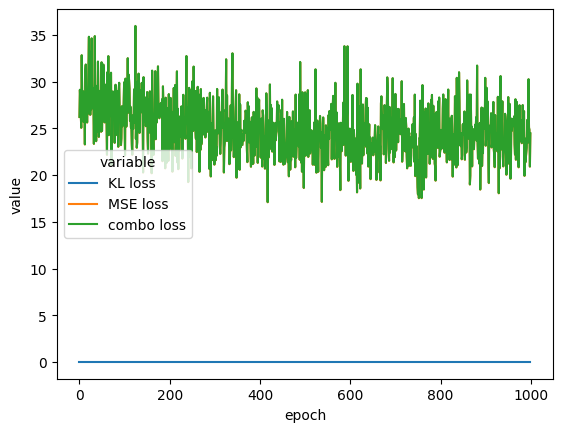

In [196]:
import seaborn as sns

h_df = pd.DataFrame.from_records(history, columns=['epoch', 'KL loss', 'MSE loss', 'combo loss'])
h_df = h_df.melt('epoch')

sns.lineplot(h_df, x='epoch', y='value', hue='variable')

## Transformer training

In [18]:
from funcs import STTFormerBayes, LitSTTFormerBayes
input_n  =10 # number of frames to train on (default=10)
output_n =25 # number of frames to predict on
input_dim=3  # dimensions of the input coordinates(default=3)
skip_rate=1  # skip rate of frames
joints_to_consider=22
model = LitSTTFormerBayes(num_joints=joints_to_consider,
                 num_frames=input_n, num_frames_out=output_n, num_heads=1,
                 num_channels=3, kernel_size=[3,3], use_pes=True)

In [21]:
from funcs import load_dataset

trainset, valset = load_dataset(input_n, output_n, skip_rate, 256)

Loading Train Dataset...


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [19]:
import lightning as L

trainer = L.Trainer(limit_train_batches=100, max_epochs=1)
trainer.fit(model=model, train_dataloaders=trainset, val_dataloaders=valset)

LitSTTFormerBayes(
  (transformer): STTFormerBayes(
    (input_map): Sequential(
      (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (blocks): ModuleList(
      (0-6): 7 x STA_Block(
        (pes): Pos_Embed()
        (to_qkvs): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
        (out_nets): Sequential(
          (0): Conv2d(16, 16, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff_net): Sequential(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (out_nett): Sequential(
          (0): Conv2d(16, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
          (1): BatchNorm2d(16, eps=1e-05

## Load old parameters into model

In [ ]:
CHK_PATH = 'data/checkpoints/h36m_3d_25frames_ckpt_epoch_40.pt'
checkpoint = torch.load(CHK_PATH)
checkpoint

#model.transformer.load_state_dict(checkpoint)

In [ ]:
checkpoint.keys() - model.transformer.state_dict().keys()